In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [129]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [130]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [132]:
df.shape

(2111, 17)

In [133]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,1.701620,86.586035,2.418986,2.685651,2.008053,1.010313,0.657861
std,6.357078,0.093368,26.191163,0.533996,0.778079,0.612950,0.850613,0.608926
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.630000,65.470000,2.000000,2.660000,1.585000,0.125000,0.000000
50%,23.000000,1.700000,83.000000,2.390000,3.000000,2.000000,1.000000,0.625000
75%,26.000000,1.770000,107.430000,3.000000,3.000000,2.480000,1.670000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## checking for missing values

In [134]:
df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [135]:
num_cols = df.select_dtypes("number")
cat_cols = df.select_dtypes("object")

## handling outliers

In [136]:
def outlier_report():
    for col in num_cols:
                    Q1 = df[col].quantile(0.25)
                    Q3 = df[col].quantile(0.75)
                    IQR=Q3-Q1
                    lower_bound = Q1-1.5*IQR
                    upper_bound = Q3+1.5*IQR

                    outlier_count = ((df[col]<lower_bound)|(df[col]>upper_bound)).sum()
                    outlier_per = (outlier_count/len(df))*100
                    print(f"{col} : {outlier_per.__round__(3)}")

outlier_report()

Age : 7.579
Height : 0.0
Weight : 0.047
FCVC : 0.0
NCP : 27.475
CH2O : 0.0
FAF : 0.0
TUE : 0.0


In [137]:
## capping outliers
for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR=Q3-Q1
        lower_bound = Q1-1.5*IQR
        upper_bound = Q3+1.5*IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [138]:
outlier_report()

Age : 0.0
Height : 0.0
Weight : 0.0
FCVC : 0.0
NCP : 0.0
CH2O : 0.0
FAF : 0.0
TUE : 0.0


## Handling skewness

In [139]:
def skewness (col):
    return df[col].skew().round(2)

for col in num_cols:
    print (f"{col} : {skewness(col)}")

Age : 0.79
Height : -0.01
Weight : 0.25
FCVC : -0.43
NCP : -0.67
CH2O : -0.11
FAF : 0.5
TUE : 0.62


No high skewness

## splitting data

In [140]:
x = df.drop('NObeyesdad',axis=1)
y= df['NObeyesdad']

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=.2,random_state=42)

## Encoding


In [141]:
for col in cat_cols:
    print(f"{col} : {df[col].nunique()}")

Gender : 2
family_history_with_overweight : 2
FAVC : 2
CAEC : 4
SMOKE : 2
SCC : 2
CALC : 4
MTRANS : 5
NObeyesdad : 7


In [142]:
## encoding 
cat_cols = x_train.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    x_train[col] = le.fit_transform(x_train[col])
    x_test[col] = le.transform(x_test[col])

x_train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
162,0,21,1.63,60.00,1,1,3.00,3.00,0,1,2.00,0,2.00,0.000,2,3
2001,0,21,1.75,133.62,1,1,3.00,3.00,2,0,2.89,0,1.48,0.780,2,3
1435,0,23,1.66,82.60,1,1,1.20,2.15,2,0,2.77,0,0.13,1.659,2,3
649,0,22,1.59,44.24,0,0,3.00,2.15,1,0,2.55,0,1.10,0.000,3,3
1280,1,26,1.81,106.04,1,1,3.00,3.00,2,0,2.86,0,1.81,0.680,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,32,1.75,120.10,1,1,2.97,3.00,2,0,2.53,0,0.96,1.339,2,0
1095,1,23,1.72,81.67,1,1,2.00,2.15,2,0,1.40,0,0.89,1.012,2,3
1130,0,23,1.65,80.00,1,1,2.00,3.00,2,0,2.00,0,0.15,2.000,3,3
1294,0,23,1.63,84.50,1,1,2.06,2.96,2,0,2.01,0,0.85,0.631,3,3


## Scaling

In [143]:
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.00,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.00,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.00,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.00,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,2.15,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Models

In [144]:
## logistic regression
lo = LogisticRegression( class_weight='balanced')
lo.fit(x_train_s,y_train)

y_pred_l = lo.predict(x_test_s)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.84      1.00      0.91        56
      Normal_Weight       0.90      0.61      0.73        62
     Obesity_Type_I       0.96      0.87      0.91        78
    Obesity_Type_II       0.88      0.97      0.92        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.75      0.79      0.77        56
Overweight_Level_II       0.75      0.86      0.80        50

           accuracy                           0.87       423
          macro avg       0.87      0.87      0.86       423
       weighted avg       0.88      0.87      0.87       423



In [145]:
## descition tree
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(x_train,y_train)

y_pred_d = dt.predict(x_test)
print(classification_report(y_test, y_pred_d))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.93      0.93        56
      Normal_Weight       0.85      0.84      0.85        62
     Obesity_Type_I       0.97      0.91      0.94        78
    Obesity_Type_II       0.93      0.95      0.94        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.88      0.91      0.89        56
Overweight_Level_II       0.92      0.98      0.95        50

           accuracy                           0.93       423
          macro avg       0.93      0.93      0.93       423
       weighted avg       0.93      0.93      0.93       423



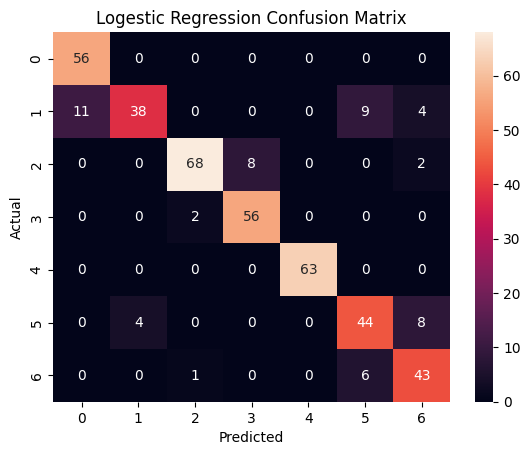

In [146]:
cm = confusion_matrix(y_test, y_pred_l)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logestic Regression Confusion Matrix")
plt.show()

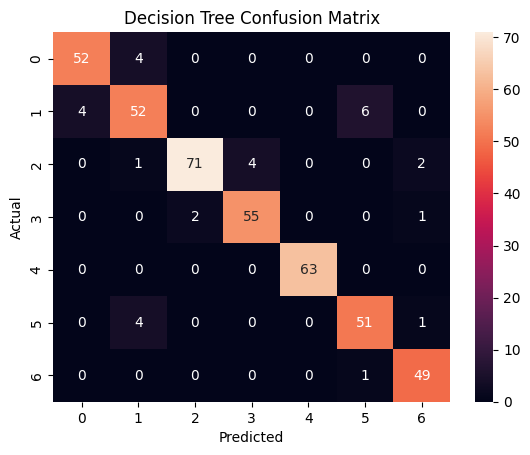

In [147]:
cm = confusion_matrix(y_test, y_pred_d)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()